In [1]:
from lightning.pytorch import seed_everything
from torch import set_float32_matmul_precision
seed_everything(42, workers=True)
set_float32_matmul_precision("medium")

Seed set to 42


In [ ]:
import torch    
# load the model
from physioex.train.models import load_model
from physioex.train.networks import config 

device = "cuda" if torch.cuda.is_available() else "cpu"

config = config["default"]
config["model_kwargs"]["in_channels"] = 1
config["model_kwargs"]["sequence_length"] = 21

model = load_model(
    model = "physioex.train.networks.tinysleepnet:TinySleepNet",
    model_kwargs = config["model_kwargs"],  
    ckpt_path = ckpt_path,
    device = device,
    softmax = True,
    summary = False,
).eval() 

# load the data
from physioex.data import PhysioExDataModule
import os 

datamodule = PhysioExDataModule(
        datasets = ["sleepedf"],
        batch_size = 256,
        data_folder = os.environ["PHYSIOEXDATA"],
        num_workers = os.cpu_count(),
)

# iterate over the test dataloader and plot the confusion matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
import torch


test_loader = datamodule.test_dataloader()
y_true = []
y_pred = []
for batch in tqdm(test_loader):
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    y_hat = model(x)
    y_true.extend(y.view(-1).cpu().numpy())
    y_pred.extend(torch.argmax(y_hat, dim=-1).view(-1).cpu().numpy())

    del x, y, y_hat
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

model = model.to("cpu")

# plot the confusion matrix

disp = ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=["Wake", "NREM1", "NREM2", "NREM3", "REM"],
    cmap=plt.cm.Blues,
    normalize="true",
    include_values=True,
    values_format=".2%",
)

# plot the classification report 
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, target_names=["Wake", "NREM1", "NREM2", "NREM3", "REM"])
print(report)

UnboundLocalError: cannot access local variable 'table' where it is not associated with a value

In [3]:
# prendiamo una sequenza temporale nella quale un epoca delle 21 epoche di input è classificata correttamente come NREM3
# e una epoca NREM2 è misclassificata 

signals, labels, predictions = [], [], []

model = model.to(device)
# iterate over the test dataloader
for batch in tqdm(test_loader):
    x, y = batch
    # x shape : batch_size, sequence_lenght, channels, time_stamps
    # y shape : batch_size, sequence_lenght
    
    # rimuovi dal batch tutte le sequenze di epoche che non contengono sia NREM3 che NREM2
    # crea una maschera booleana per il batch
    mask = torch.zeros(x.shape[0], dtype=torch.bool)
    for i in range(x.shape[0]):
        if any(y[i] == 1) and any(y[i] == 3):
            mask[i] = True
    # applica la maschera al batch
    x = x[mask]
    y = y[mask]    
    
    # controlla se il batch è vuoto
    if x.shape[0] == 0:
        continue
    
    x = x.to(device)
    y_hat = model(x).cpu()
    
    # salva le sequenze temporali e le etichette
    
    signals.append(x.cpu().numpy())
    labels.append(y.cpu().numpy())
    predictions.append(y_hat.cpu().detach().numpy())
    
    del x, y, y_hat

model = model.to("cpu")

signals = np.concatenate(signals, axis=0)
labels = np.concatenate(labels, axis=0)
predictions = np.concatenate(predictions, axis=0)

print(signals.shape, labels.shape, predictions.shape)

100%|██████████| 103/103 [00:02<00:00, 50.16it/s]

(1366, 21, 1, 3000) (1366, 21) (1366, 21, 5)


In [4]:
def stopband_filter(x, fs, cutoff, filter_type="low", order=5):
    from scipy import signal    

    if filter_type == "low":
        b, a = signal.butter(order, cutoff, fs = fs, btype='lowpass')
    elif filter_type == "high":
        b, a = signal.butter(order, cutoff, fs = fs, btype='highpass')
    else:
        raise ValueError("filter_type must be 'low' or 'high'")

    return signal.filtfilt(b, a, x)


def isolate_bands(signals, fs=100 ):

    in_shape = signals.shape
    # in_shape : batch_size, sequence_length, channels, time_stamps
    
    if len( in_shape ) == 4: # batched data
        signals = np.reshape( signals, (signals.shape[0], -1))
    else: # unbatched data
        signals = np.reshape( signals, -1)
        
    
    gamma = stopband_filter( signals, fs, 30 )
    beta = stopband_filter( gamma, fs, 14 )
    sigma = stopband_filter( beta, fs, 12 )
    alpha = stopband_filter( sigma, fs, 8 )
    theta = stopband_filter( alpha, fs, 4 )
    delta = np.zeros_like( signals )
    
    bands = np.stack([ signals, gamma, beta, sigma, alpha, theta, delta], axis=0)
            
    # Reshape back to the format NUM_WINDOWS, BANDS, N_TIMESTAMPS
    bands = np.reshape(bands, (7, *in_shape))    
    return bands.astype( np.float32 )

Found index 145 with more NREM3 than NREM2
(63000,)
Importance for NREM1
Epoch 11: NREM1 confidence 0.01162736862897873
Gamma: 0.005321867298334837
Beta: 0.00445348909124732
Sigma: 0.0
Alpha: 0.0003454549005255103
Theta: 0.0
Delta: 0.0
Epoch 12: NREM1 confidence 0.021969491615891457
Gamma: 0.008275274187326431
Beta: 0.00945078395307064
Sigma: 0.0
Alpha: 0.0012796788942068815
Theta: 0.0
Delta: 0.0
Epoch 13: NREM1 confidence 0.011108122766017914
Gamma: 0.0019922656938433647
Beta: 0.005528516601771116
Sigma: 0.0
Alpha: 0.0006244191899895668
Theta: 0.0
Delta: 0.0
Epoch 14: NREM1 confidence 0.006349693983793259
Gamma: 0.000593157485127449
Beta: 0.0021735893096774817
Sigma: 0.0
Alpha: 0.0009248526766896248
Theta: 0.0
Delta: 0.0


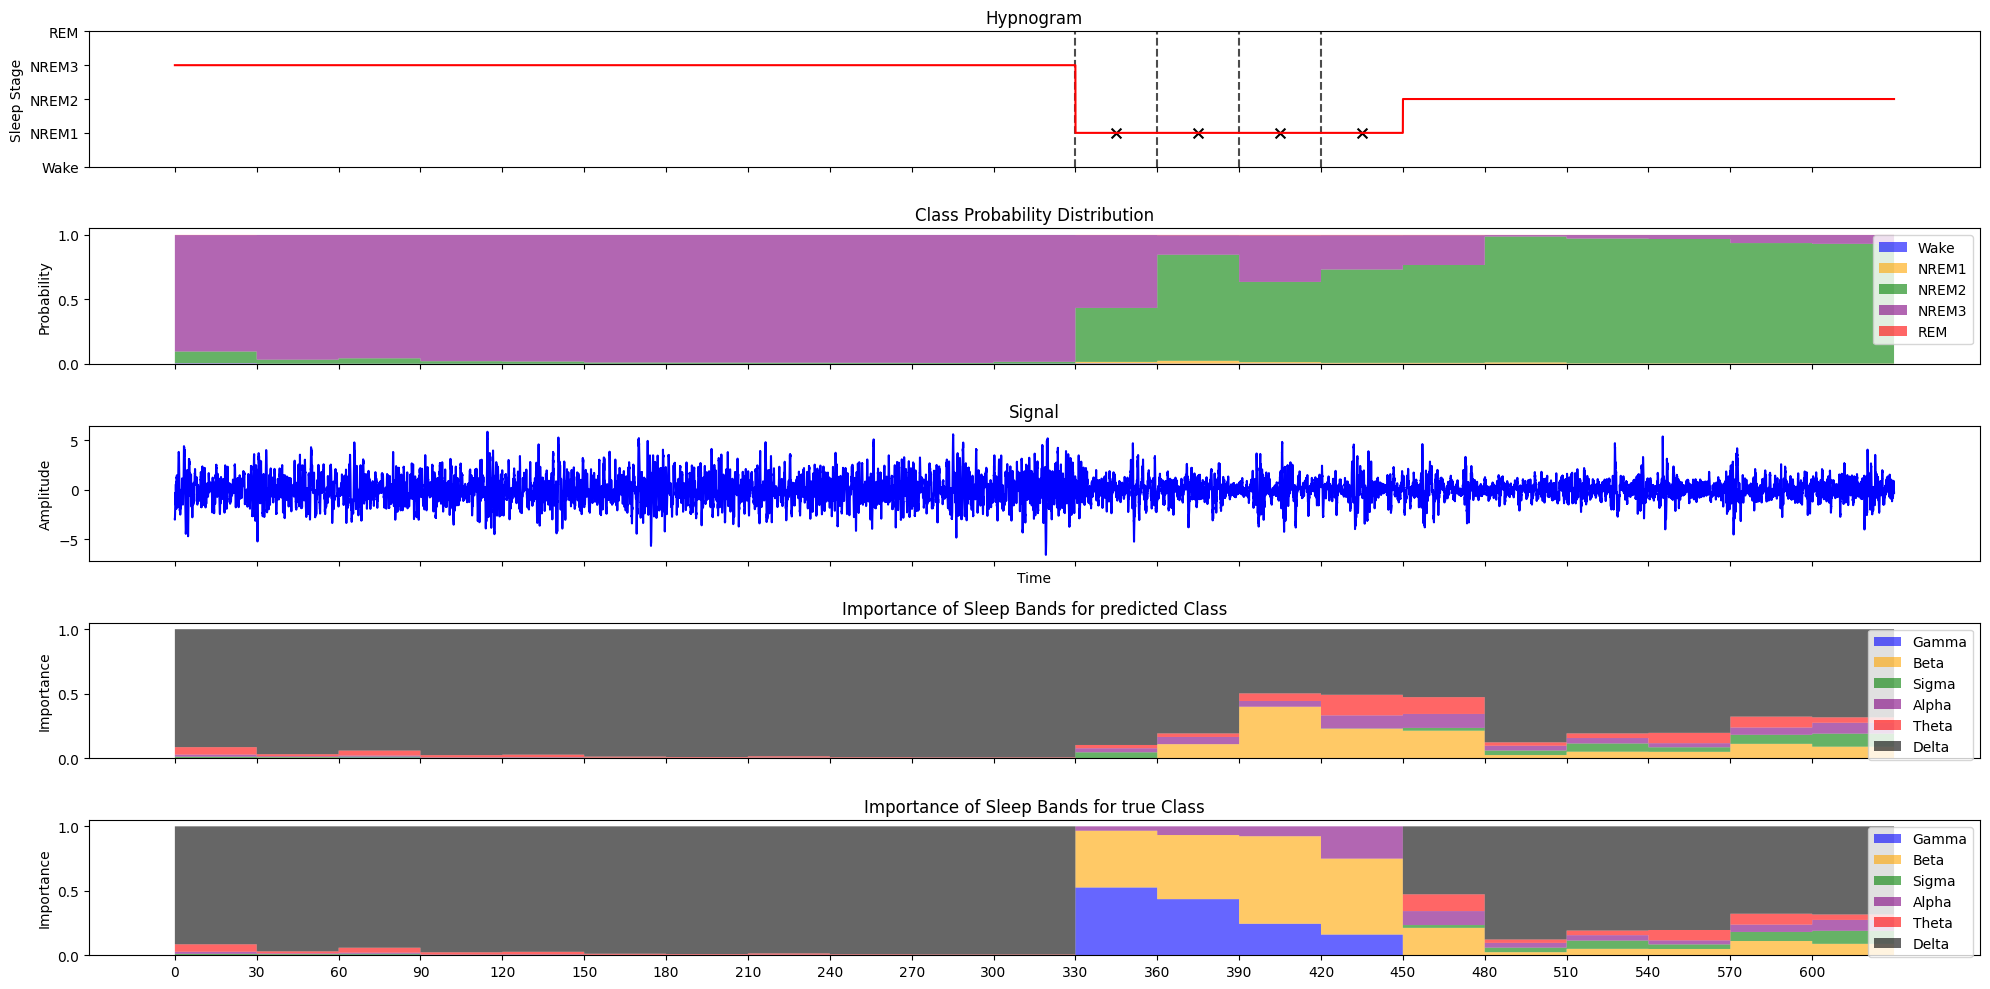

In [5]:
# scrivi uno script che dato l'indice di una sequenza ( indx di signals )
# esegua il plot della sequenza temporale (signal), del suo hypnogram (label) della sua distribuzione di predizione (prediction)
# e della distribuzione di probabilità assegnata a ogni banda del sonno

import matplotlib.pyplot as plt
import numpy as np


idx = 0

# cerca un epoca nella quale ci siano più NREM3 che NREM2
for i in range(labels.shape[0]):
    if np.sum( labels[i] == 3 ) > np.sum( labels[i] == 2 ):
        if np.sum( labels[i] == 2 ) > 5:
            idx = i    
            print(f"Found index {idx} with more NREM3 than NREM2")
            break

#idx = 85
    
signal = signals[idx]
label = labels[idx]
prediction = predictions[idx]

# crea un plot a tre righe, in basso va il segnale, in mezzo l'hypnogram e in alto la distribuzione delle predizioni
fig, axs = plt.subplots(5, 1, figsize=(20, 10), sharex=True)
# plot the signal
axs[2].plot(signal.reshape(-1), color="blue")
axs[2].set_title("Signal")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Amplitude")

# set the x ticks to be every 3000 samples --> every 30 seconds
axs[2].set_xticks(np.arange(0, 21*3000, 3000))
axs[2].set_xticklabels( (np.arange(0, 21*3000, 3000) / 100 ).astype(int) )

# plot the hypnogram

# label shape : (21,) --> 21 * 3000
label = np.repeat(label.reshape(21, 1), 3000, axis=1).reshape(-1)
print(label.shape)

# Predizioni più probabili per ogni epoca
predicted_labels = np.argmax(prediction.reshape(21, 5), axis=1)
# Trova le epoche misclassificate
misclassified_epochs = np.where(predicted_labels != labels[idx])[0]

# Aggiungi marker per le epoche misclassificate
for epoch in misclassified_epochs:
    axs[0].axvline(x=epoch * 3000, color="black", linestyle="--", alpha=0.7)
    axs[0].scatter(epoch * 3000 + 1500, labels[idx][epoch], color="black", marker="x", s=50, label="Misclassified" if epoch == misclassified_epochs[0] else "")

axs[0].plot(label, color="red")
axs[0].set_title("Hypnogram")
axs[0].set_ylabel("Sleep Stage")

# cambia le y labels dagli indici a Wake, NREM1, NREM2, NREM3, REM
axs[0].set_yticks([0, 1, 2, 3, 4])
axs[0].set_yticklabels(["Wake", "NREM1", "NREM2", "NREM3", "REM"])



# plot the class probability distribution over time
# prediction shape : (21, 5) --> 21 * 3000, 5
prediction = np.repeat(prediction.reshape(21, 1, 5), 3000, axis=1).reshape(-1, 5)


# Calcola il tempo (asse x)
time = np.arange(prediction.shape[0])

# Crea il grafico a barre impilate normalizzate
axs[1].stackplot(
    time,
    prediction.T,  # Trasponi per avere ogni classe come una serie
    labels=["Wake", "NREM1", "NREM2", "NREM3", "REM"],
    colors=["blue", "orange", "green", "purple", "red"],
    alpha=0.6,
)

axs[1].set_title("Class Probability Distribution")
axs[1].set_ylabel("Probability")
axs[1].legend(loc="upper right")


# estrai le bande di frequenza dal segnale

bands = isolate_bands(signal)
# bands shape : (7, 21, 3000)

# calcola l'importanza associata ad ogni banda : gamma, beta, sigma, alpha, theta, delta
importances = np.zeros( (6, 21, 5), dtype=np.float32 ) 
model = model.to(device)
for i in range(1, bands.shape[0] ):
    # l'importanza della banda i-esima è calcolata come f(x_i) - f(x_{i-1})
    x = torch.tensor( bands[i-1], dtype=torch.float32 ).to(device).unsqueeze(0)
    x_i = torch.tensor( bands[i], dtype=torch.float32 ).to(device).unsqueeze(0)
    importances[ i - 1] = ( model( x ) - model( x_i ) ).squeeze(0).cpu().detach().numpy()
    # se ci sono valori negativi, mettili a zero
    importances[ i - 1][importances[ i - 1] < 0] = 0
    
    del x, x_i
model = model.to("cpu")

# printa l'importanza per la classe NREM1 delle bande per le epoche NREM1
print("Importance for NREM1")
for i in range(21):
    if labels[idx][i] == 1:
        print(f"Epoch {i}: NREM1 confidence { predictions[idx][i][1] }")
        print(f"Gamma: {importances[0][i][1]}")
        print(f"Beta: {importances[1][i][1]}")
        print(f"Sigma: {importances[2][i][1]}")
        print(f"Alpha: {importances[3][i][1]}")
        print(f"Theta: {importances[4][i][1]}")
        print(f"Delta: {importances[5][i][1]}")

# crea la variabile importance che seleziona l'importanza per la sola classe predetta
importance_pred = np.zeros( (21, 6), dtype=np.float32 )
importance_true = np.zeros( (21, 6), dtype=np.float32 )

for i in range(21):
    pred = np.argmax(predictions[idx][i])
    true = labels[idx][i]
    importance_pred[i] = importances[:, i, pred].T
    importance_true[i] = importances[:, i, true].T

    # normalizziamo l'importanza in modo che la somma delle importanze sia 1
    importance_pred[i] = importance_pred[i] / np.sum(importance_pred[i])
    importance_true[i] = importance_true[i] / np.sum(importance_true[i])

# importance shape : (21, 6) --> 21*3000, 6
importance_pred = np.repeat(importance_pred.reshape(21, 1, 6), 3000, axis=1).reshape(-1, 6)
importance_true = np.repeat(importance_true.reshape(21, 1, 6), 3000, axis=1).reshape(-1, 6)
    
# plotta l'importanza per ogni banda in maniera simile a come è stato fatto per la distribuzione di probabilità
axs[3].stackplot(
    time,
    importance_pred.T,  # Trasponi per avere ogni classe come una serie
    labels=["Gamma", "Beta", "Sigma", "Alpha", "Theta", "Delta"],
    # cambia i colori in modo che transiscano da scuro a chiaro a seconda della frequenza ( alta, bassa)
    colors=["blue", "orange", "green", "purple", "red", "black"],
    alpha=0.6,
)
axs[3].set_title("Importance of Sleep Bands for predicted Class")
axs[3].legend(loc="upper right")
axs[3].set_ylabel("Importance")    

axs[4].stackplot(
    time,
    importance_true.T,  # Trasponi per avere ogni classe come una serie
    labels=["Gamma", "Beta", "Sigma", "Alpha", "Theta", "Delta"],
    # cambia i colori in modo che transiscano da scuro a chiaro a seconda della frequenza ( alta, bassa)
    colors=["blue", "orange", "green", "purple", "red", "black"],
    alpha=0.6,
)
axs[4].set_title("Importance of Sleep Bands for true Class")
axs[4].legend(loc="upper right")
axs[4].set_ylabel("Importance")    


plt.tight_layout()

In [6]:

# cerchiamo di valutare il potere predittivo delle spiegazioni

# per ogni elemento del training set, calcoliamo l' importanza della true-class e rimuoviamo le missclassificate

train_loader = datamodule.train_dataloader()
importances, y_true, y_hats = [], [], []
model = model.to(device)    
for batch in tqdm(train_loader):
    x, y = batch
    # x shape : batch_size, sequence_lenght, channels, time_stamps
    # y shape : batch_size, sequence_lenght
    
    bands = torch.tensor( isolate_bands(x.cpu().numpy()), dtype=torch.float32 )
    # bands shape : (7, batch_size, 21, 1, 3000)

    y_hat = model( bands[0].to(device)).cpu().detach().numpy()

    predictions = np.argmax(y_hat, axis= -1).reshape(-1)
    y = y.cpu().numpy().reshape(-1)
    
    # calcola l'importanza per ogni banda
    importance = np.zeros( ( 6, bands.shape[1], 21, 5 ), dtype=np.float32 )
    for i in range(1, bands.shape[0] ):
        # l'importanza della banda i-esima è calcolata come f(x_i) - f(x_{i-1})
        x = bands[i-1].to(device)
        x_i = bands[i].to(device)
        importance[ i - 1] = ( model( x ) - model( x_i ) ).cpu().detach().numpy()
        # se ci sono valori negativi, mettili a zero
        importance[ i - 1][importance[ i - 1] < 0] = 0        
    
    importance = importance.reshape(6, -1, 5)
    
    # rimuovi gli elementi misclassificati
    mask = np.zeros(importance.shape[1], dtype=bool)
    for i in range(importance.shape[1]):
        if predictions[i] == y[i]:
            mask[i] = True

    # applica la maschera
    importance = importance[:, mask]
    y = y.reshape(-1)[mask]
    y_hat = y_hat.reshape(-1, 5)[mask]
    
    # salva le importanze
    importances.append(importance)
    y_true.append(y)
    y_hats.append(y_hat)

model = model.to("cpu")         

importances = np.concatenate(importances, axis=1)
y_true = np.concatenate(y_true, axis=0)
y_hats = np.concatenate(y_hats, axis=0)

print(importances.shape, y_true.shape, y_hats.shape)    



100%|██████████| 509/509 [16:43<00:00,  1.97s/it]

(6, 2329377, 5) (2329377,) (2329377, 5)


In [7]:
importances = np.transpose(importances, (1, 0, 2) )
print(importances.shape) # (batch_size, 6, 5)

(2329377, 6, 5)


In [ ]:
true_importances = []

for i in range( importances.shape[0] ):
    true_importances.append( importances[i][ :, y_true[i] ] )
true_importances = np.array( true_importances )

print(true_importances.shape) 

# evaluate the predictive power of the explanations
# for each element in the testing set predict the target class using a k-nn classifier trained on the training set
# at the end print the confusion matrix and the classification report

test_loader = datamodule.test_dataloader()
importances_test, y_true_test, y_hats_test = [], [], []
model = model.to(device)

for batch in tqdm(test_loader):
    x, y = batch
    # x shape : batch_size, sequence_lenght, channels, time_stamps
    # y shape : batch_size, sequence_lenght
    
    bands = torch.tensor( isolate_bands(x.cpu().numpy()), dtype=torch.float32 )
    # bands shape : (7, batch_size, 21, 1, 3000)

    y_hat = model( bands[0].to(device)).cpu().detach().numpy()

    predictions = np.argmax(y_hat, axis= -1).reshape(-1)
    y = y.cpu().numpy().reshape(-1)
    
    # calcola l'importanza per ogni banda
    importance = np.zeros( ( 6, bands.shape[1], 21, 5 ), dtype=np.float32 )
    for i in range(1, bands.shape[0] ):
        # l'importanza della banda i-esima è calcolata come f(x_i) - f(x_{i-1})
        x = bands[i-1].to(device)
        x_i = bands[i].to(device)
        importance[ i - 1] = ( model( x ) - model( x_i ) ).cpu().detach().numpy()
        # se ci sono valori negativi, mettili a zero
        importance[ i - 1][importance[ i - 1] < 0] = 0        
    
    importance = importance.reshape(6, -1, 5)
    
    # rimuovi gli elementi misclassificati
    mask = np.zeros(importance.shape[1], dtype=bool)
    for i in range(importance.shape[1]):
        if predictions[i] == y[i]:
            mask[i] = True

    # applica la maschera
    importance = importance[:, mask]
    y = y.reshape(-1)[mask]
    y_hat = y_hat.reshape(-1, 5)[mask]
    
    # salva le importanze
    importances_test.append(importance)
    y_true_test.append(y)
    y_hats_test.append(y_hat)
model = model.to("cpu")
importances_test = np.concatenate(importances_test, axis=1)
y_true_test = np.concatenate(y_true_test, axis=0)
y_hats_test = np.concatenate(y_hats_test, axis=0)
print(importances_test.shape, y_true_test.shape, y_hats_test.shape)



(2329377, 6)


 27%|██▋       | 28/103 [00:56<02:29,  1.99s/it]

100%|██████████| 103/103 [03:22<00:00,  1.97s/it]

(6, 452682, 5) (452682,) (452682, 5)


In [11]:
val_loader = datamodule.val_dataloader()
importances_val, y_true_val, y_hats_val = [], [], []
model = model.to(device)

for batch in tqdm(val_loader):
    x, y = batch
    # x shape : batch_size, sequence_lenght, channels, time_stamps
    # y shape : batch_size, sequence_lenght
    
    bands = torch.tensor( isolate_bands(x.cpu().numpy()), dtype=torch.float32 )
    # bands shape : (7, batch_size, 21, 1, 3000)

    y_hat = model( bands[0].to(device)).cpu().detach().numpy()

    predictions = np.argmax(y_hat, axis= -1).reshape(-1)
    y = y.cpu().numpy().reshape(-1)
    
    # calcola l'importanza per ogni banda
    importance = np.zeros( ( 6, bands.shape[1], 21, 5 ), dtype=np.float32 )
    for i in range(1, bands.shape[0] ):
        # l'importanza della banda i-esima è calcolata come f(x_i) - f(x_{i-1})
        x = bands[i-1].to(device)
        x_i = bands[i].to(device)
        importance[ i - 1] = ( model( x ) - model( x_i ) ).cpu().detach().numpy()
        # se ci sono valori negativi, mettili a zero
        importance[ i - 1][importance[ i - 1] < 0] = 0        
    
    importance = importance.reshape(6, -1, 5)
    
    # rimuovi gli elementi misclassificati
    mask = np.zeros(importance.shape[1], dtype=bool)
    for i in range(importance.shape[1]):
        if predictions[i] == y[i]:
            mask[i] = True

    # applica la maschera
    importance = importance[:, mask]
    y = y.reshape(-1)[mask]
    y_hat = y_hat.reshape(-1, 5)[mask]
    
    # salva le importanze
    importances_val.append(importance)
    y_true_val.append(y)
    y_hats_val.append(y_hat)
model = model.to("cpu")

importances_val = np.concatenate(importances_val, axis=1)
y_true_val = np.concatenate(y_true_val, axis=0)
y_hats_val = np.concatenate(y_hats_val, axis=0)
print(importances_val.shape, y_true_val.shape, y_hats_val.shape)



  0%|          | 0/143 [00:00<?, ?it/s]

100%|██████████| 143/143 [04:44<00:00,  1.99s/it]

(6, 639214, 5) (639214,) (639214, 5)


In [12]:
importances_val = np.transpose(importances_val, (1, 0, 2) )
print(importances_val.shape) # (batch_size, 6, 5)

(639214, 6, 5)


In [14]:
importances_test = np.transpose(importances_test, (1, 0, 2) )
print(importances_test.shape) # (batch_size, 6, 5)

(452682, 6, 5)


In [18]:
print( y_hats_val.shape, y_true_val.shape )
print( y_hats_test.shape, y_true_test.shape )

(639214, 5) (639214,)
(452682, 5) (452682,)


In [1]:


# train a k-nn classifier on the training set
from sklearn.neighbors import KNeighborsClassifier
#knn = KNeighborsClassifier(n_neighbors=5).fit( true_importances, y_true )

ks = [1, 3, 5, 7, 9]
best_k, best_acc = 0, 0

tmp = np.copy(importances_val)
tmp = np.transpose(tmp, (0, 2, 1) ).reshape(-1, 6)

tmp_preds = np.copy( y_hats_val )
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k).fit( true_importances, y_true )

    # tmp shape : (batch_size * 5, 6)
    y_imp_preds = knn.predict_proba(tmp) # shape (batch_size * 5, 5)
    y_imp_preds = y_imp_preds.reshape(-1, 5, 5) # shape (batch_size, 5, 5)

    # prendi gli elementi sulla diagonale per avere le probabilità di ogni classe
    y_imp_preds = y_imp_preds.diagonal(axis1=1, axis2=2) # shape (batch_size, 5)
    # prendi la classe con la probabilità maggiore
    
    # integra le predizioni del modello
    
    y_imp_preds = y_imp_preds + tmp_preds
    
    y_imp_preds = np.argmax(y_imp_preds, axis=1) # shape (batch_size, 5)
    
    # calcola l'accuratezza
    acc = np.sum(y_imp_preds == y_true_val) / y_true_val.shape[0]
    print(f"Accuracy for k={k}: {acc}")
    if acc > best_acc:
        best_acc = acc
        best_k = k


print(f"Best k: {best_k} with accuracy {best_acc}")

knn = KNeighborsClassifier(n_neighbors=best_k).fit( true_importances, y_true )

# per testare il k-nn classifier, per ogni elemento del test set calcola la predict_proba riferita ad ogni classe

# importances_test shape : (batch_size, 6, 5)
tmp = np.copy(importances_test)
tmp = np.transpose(tmp, (0, 2, 1) ).reshape(-1, 6)
tmp_preds = np.copy( y_hats_test )

# tmp shape : (batch_size * 5, 6)
y_imp_preds = knn.predict_proba(tmp) # shape (batch_size * 5, 5)
y_imp_preds = y_imp_preds.reshape(-1, 5, 5) # shape (batch_size, 5, 5)

# prendi gli elementi sulla diagonale per avere le probabilità di ogni classe
y_imp_preds = y_imp_preds.diagonal(axis1=1, axis2=2) # shape (batch_size, 5)
y_imp_preds = y_imp_preds + tmp_preds

# prendi la classe con la probabilità maggiore
y_imp_preds = np.argmax(y_imp_preds, axis=1) # shape (batch_size, 5)

print(y_imp_preds.shape, y_true_test.shape)

# visualizza la matrice di confusione
disp = ConfusionMatrixDisplay.from_predictions(
    y_true_test,
    y_imp_preds,
    display_labels=["Wake", "NREM1", "NREM2", "NREM3", "REM"],
    cmap=plt.cm.Blues,
    normalize="true",
    include_values=True,
    values_format=".2%",
)

# plot the classification report 
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true_test, y_imp_preds, target_names=["Wake", "NREM1", "NREM2", "NREM3", "REM"])
print(report)

NameError: name 'np' is not defined